In [ ]:
import pandas as pd
import numpy as np
import re
import json
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, roc_curve, precision_score, recall_score
import scikitplot as skplt
import pytz
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from textblob import TextBlob
import datetime

In [157]:
def preprocess_data(data):
        non_url = re.sub(r"http\S+", "", data)
        letters_only = re.sub("[^a-zA-Z]", " ", non_url)
        words = letters_only.split()
        return(" ".join( words ))

In [84]:
pst_tz = pytz.timezone('US/Pacific')
with open("tweet_data/tweets_superbowl.txt",'r') as f:
        for length,l in enumerate(f):
            pass
        print("number of lines = " + str(length))
        df = pd.DataFrame(index=np.arange(length), columns=['time_of_tweet', 'text', 'num_of_budweiser', 'num_of_fiat', 'num_of_microsoft', 'num_of_doritos',"num_of_cocacola"])
       
        #df = pd.DataFrame(columns = ['time_of_tweet', 'num_of_tweets', 'num_retweets', 'sum_followers', 'max_followers'])
        with open("tweet_data/tweets_superbowl.txt",'r') as f:
            for i,line in enumerate(f):
                if i % 50000 == 0:
                    print(str(i) + " lines completed")
                    #break
                tweet = json.loads(line)
                if(tweet['tweet']['lang'] != 'en'):
                    continue
                time_of_tweet = datetime.datetime.fromtimestamp(tweet['citation_date'],pst_tz)
                #num_of_tweets = 1
                text = tweet['tweet']['text']
                text = text.lower()
                if 'fiat' in text:
                    num_of_fiat = 1
                else:
                    num_of_fiat = 0
                if 'budweiser' in text:
                    num_of_budweiser = 1
                else:
                    num_of_budweiser = 0
                if 'doritos' in text:
                    num_of_doritos = 1
                else:
                    num_of_doritos = 0
                if 'cocacola' in text or 'coke' in text:
                    num_of_cocacola = 1
                else:
                    num_of_cocacola = 0
                if 'microsoft' in text:
                    num_of_microsoft = 1
                else:
                    num_of_microsoft = 0
                
                df.set_value(i, 'text' ,text)
                df.set_value(i,'time_of_tweet', time_of_tweet)
                df.set_value(i,'num_of_fiat', num_of_fiat)
                df.set_value(i,'num_of_doritos', num_of_doritos)
                df.set_value(i,'num_of_budweiser', num_of_budweiser)
                df.set_value(i,'num_of_cocacola', num_of_cocacola)
                df.set_value(i,'num_of_microsoft', num_of_microsoft)
                
                
                
                
                


number of lines = 1348766
0 lines completed


C:\Python27\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Python27\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Python27\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Python27\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Python27\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Python27\lib\site-packages\ipykernel_launcher.py:47: FutureWarning: set_value is deprecated 

50000 lines completed
100000 lines completed
150000 lines completed
200000 lines completed
250000 lines completed
300000 lines completed
350000 lines completed
400000 lines completed
450000 lines completed
500000 lines completed
550000 lines completed
600000 lines completed
650000 lines completed
700000 lines completed
750000 lines completed
800000 lines completed
850000 lines completed
900000 lines completed
950000 lines completed
1000000 lines completed
1050000 lines completed
1100000 lines completed
1150000 lines completed
1200000 lines completed
1250000 lines completed
1300000 lines completed


In [85]:
df_fiat = df.loc[df['num_of_fiat'] == 1, ['text', 'time_of_tweet']]
df_fiat.to_csv('fiat.csv', encoding ='utf-8')
df_doritos = df.loc[df['num_of_doritos'] == 1, ['text', 'time_of_tweet']]
df_doritos.to_csv('doritos.csv', encoding ='utf-8')
df_budweiser = df.loc[df['num_of_budweiser'] == 1, ['text', 'time_of_tweet']]
df_budweiser.to_csv('budweiser.csv', encoding ='utf-8')
df_cocacola = df.loc[df['num_of_cocacola'] == 1, ['text', 'time_of_tweet']]
df_cocacola.to_csv('cocacola.csv', encoding ='utf-8')
df_microsoft = df.loc[df['num_of_microsoft'] == 1, ['text', 'time_of_tweet']]
df_microsoft.to_csv('microsoft.csv', encoding ='utf-8')

In [166]:
def compute_graph_hr(df):
    df_sent = []
    np_df = df.as_matrix()
    print(len(np_df))
    for i in range(0,len(np_df)):
        tweet = np_df[i,0]
        sentiment = TextBlob(preprocess_data(tweet)).sentiment.polarity
        if sentiment == 0:
            df_sent.append("neutral")
        elif sentiment > 0:
            df_sent.append("positive")
        else:
            df_sent.append("negative")
    
    df_dict = {}
    for i in range(0,len(df_sent)):
        d = np_df[i,1]
        date = str(d.month) + '-' + str(d.day)
        minute = d.minute
        key = str(d.hour)+':'+str(d.minute)+':'+str(d.second)
        if date=='2-1' and key in df_dict:
            if df_sent[i] == 'positive':
                df_dict[d][0]+=1
            elif df_sent[i] == 'negative':
                df_dict[d][1]+=1
        elif date == '2-1':
            if df_sent[i] == 'positive':
                df_dict[d] = [1,0]
            elif df_sent[i] == 'negative':
                df_dict[d] = [0,1]
    
    a = df_dict.keys()
    b = df_dict.values()
    temp = pd.DataFrame(a, columns=['time'])
    temp['positive'] = [i[0] for i in b]
    temp['negative'] = [i[1] for i in b]
    return temp

4890
1064


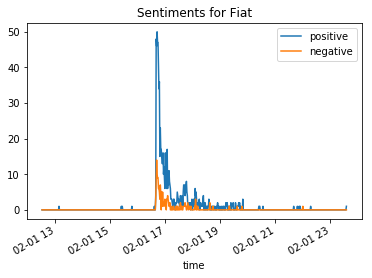

In [204]:
x = compute_graph_hr(df_fiat)
x = x.set_index(['time'])
print(len(x))
t = x.resample('1T').sum()
l = t[t.index > '2015-02-01 12:30:00-08:00']
l.plot(title='Sentiments for Fiat')

In [205]:
g = l[l.index > '2015-02-01 16:30:00-08:00' ]
g[g.index < '2015-02-01 17:30:00-08:00']

,positive,negative
time,,
2015-02-01 16:31:00-08:00,0,0
2015-02-01 16:32:00-08:00,0,0
2015-02-01 16:33:00-08:00,0,0
2015-02-01 16:34:00-08:00,0,0
2015-02-01 16:35:00-08:00,0,0
2015-02-01 16:36:00-08:00,1,0
2015-02-01 16:37:00-08:00,0,0
2015-02-01 16:38:00-08:00,0,0
2015-02-01 16:39:00-08:00,4,3


3156


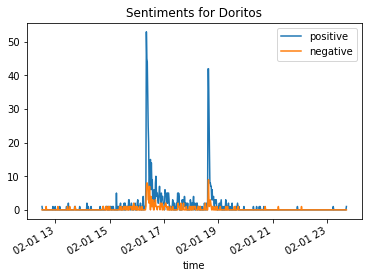

In [206]:
x = compute_graph_hr(df_doritos)
x = x.set_index(['time'])
t = x.resample('1T').sum()
l = t[t.index > '2015-02-01 12:30:00-08:00']
l.plot(title='Sentiments for Doritos')

In [210]:
g = l[l.index > '2015-02-01 18:30:00-08:00' ]
g[g.index < '2015-02-01 19:30:00-08:00']

,positive,negative
time,,
2015-02-01 18:31:00-08:00,0,2
2015-02-01 18:32:00-08:00,0,1
2015-02-01 18:33:00-08:00,2,0
2015-02-01 18:34:00-08:00,1,0
2015-02-01 18:35:00-08:00,0,0
2015-02-01 18:36:00-08:00,2,0
2015-02-01 18:37:00-08:00,42,4
2015-02-01 18:38:00-08:00,42,9
2015-02-01 18:39:00-08:00,29,2


10424


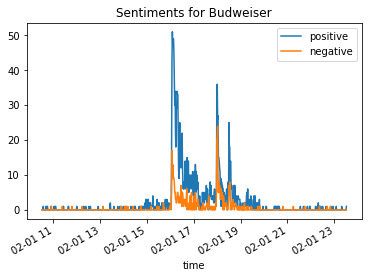

In [211]:
x = compute_graph_hr(df_budweiser)
x = x.set_index(['time'])
t = x.resample('1T').sum()
l = t[t.index > '2015-02-01 10:30:00-08:00']
l.plot(title='Sentiments for Budweiser')

In [220]:
g = l[l.index > '2015-02-01 18:20:00-08:00' ]
g[g.index < '2015-02-01 19:15:00-08:00']

,positive,negative
time,,
2015-02-01 18:21:00-08:00,4,2
2015-02-01 18:22:00-08:00,3,2
2015-02-01 18:23:00-08:00,4,1
2015-02-01 18:24:00-08:00,6,1
2015-02-01 18:25:00-08:00,4,0
2015-02-01 18:26:00-08:00,0,0
2015-02-01 18:27:00-08:00,6,0
2015-02-01 18:28:00-08:00,8,1
2015-02-01 18:29:00-08:00,4,3


1760


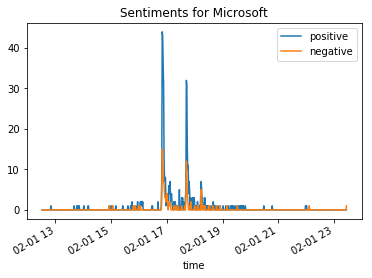

In [195]:
x = compute_graph_hr(df_microsoft)
x = x.set_index(['time'])
t = x.resample('1T').sum()
l = t[t.index > '2015-02-01 12:30:00-08:00']
l.plot(title='Sentiments for Microsoft')

In [225]:
g = l[l.index > '2015-02-01 17:45:00-08:00' ]
g[g.index < '2015-02-01 18:45:00-08:00']

,positive,negative
time,,
2015-02-01 17:46:00-08:00,3,0
2015-02-01 17:47:00-08:00,4,1
2015-02-01 17:48:00-08:00,3,0
2015-02-01 17:49:00-08:00,4,0
2015-02-01 17:50:00-08:00,3,0
2015-02-01 17:51:00-08:00,2,0
2015-02-01 17:52:00-08:00,5,1
2015-02-01 17:53:00-08:00,6,0
2015-02-01 17:54:00-08:00,5,0
